# ***Trend Changepoints***

## ***Automatic trend changepoint detection***

### *Default changepoint detection*

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

df = pd.read_csv('../data/divvy_daily.csv')
df = df[['date', 'rides']]
df['date'] = pd.to_datetime(df['date'])
df.columns = ['ds', 'y']

In [9]:
import numpy as np

def set_changepoints(df, n_changepoints, changepoint_range):
    """Set changepoints
    Sets changepoints to the dates of changepoints. Either:
    1) We are generating a grid of them.
    2) The user prefers no changepoints be used.
    """
    df = df.sort_values('ds').reset_index(drop=True)
    # Place potential changepoints evenly through first
    # `changepoint_range` proportion of the history
    hist_size = int(np.floor(df.shape[0] * changepoint_range))
    if n_changepoints + 1 > hist_size:
        n_changepoints = hist_size - 1
        print('n_changepoints greater than number of observations. Using {}.'.format(n_changepoints))
    if n_changepoints > 0:
        cp_indexes = np.linspace(0,
                                 hist_size - 1,
                                 n_changepoints + 1).round().astype(np.int16)
        changepoints = df.iloc[cp_indexes]['ds'].tail(-1)
    else:
        # set empty changepoints
        changepoints = pd.Series(pd.to_datetime([]), name='ds')
    return changepoints

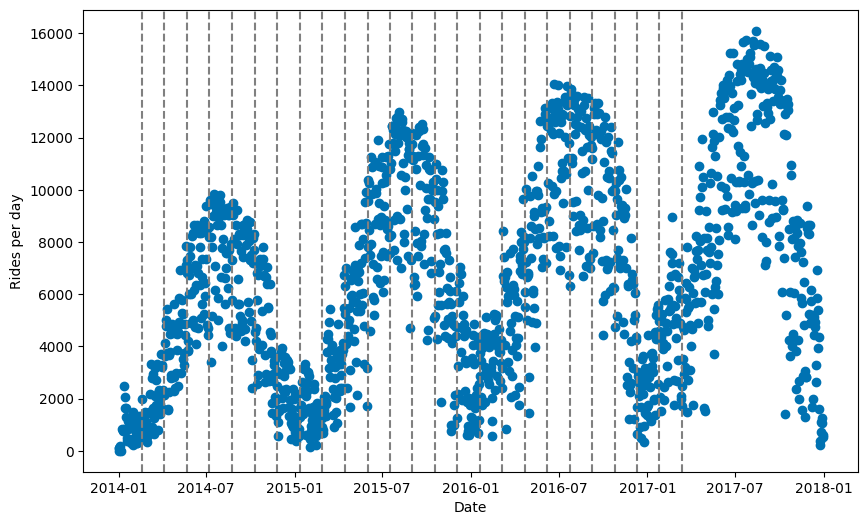

In [10]:
changepoints = set_changepoints(df, 25, .8)

plt.figure(figsize=(10, 6))
plt.scatter(df['ds'], df['y'], c='#0072B2')
for cp in changepoints:
    plt.axvline(x=cp, c='gray', ls='--')
plt.xlabel('Date')
plt.ylabel('Rides per day')
plt.show()

# Prophet's default 25 changepoints

In [11]:
model = Prophet(seasonality_mode='multiplicative',
                yearly_seasonality=4)
model.fit(df)

# with no future
forecast = model.predict()

14:55:18 - cmdstanpy - INFO - Chain [1] start processing
14:55:19 - cmdstanpy - INFO - Chain [1] done processing


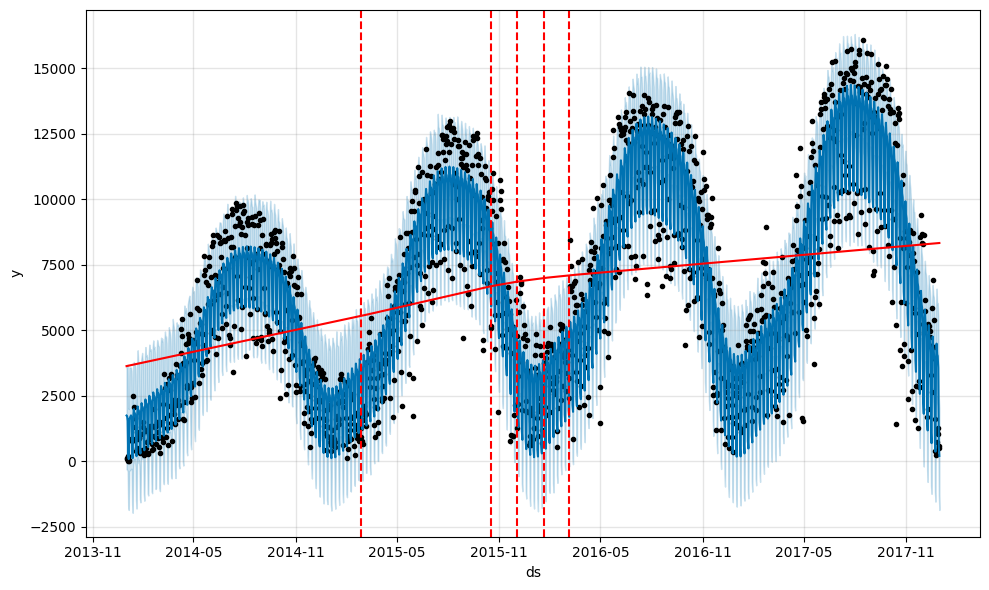

In [14]:
fig = model.plot(forecast)
add_changepoints_to_plot(fig.gca(), model, forecast)
plt.show()

# see adjusted changepoints

In [12]:
## changepoints magnitude , 'delta' key
## Normalized value
print(model.params['delta'])

[[-7.73220e-10  7.62750e-09  1.88243e-08 -5.01128e-07 -1.93627e-09
  -2.03254e-08  2.51779e-08  1.04897e-04  3.02188e-02  6.57099e-04
   4.40066e-09  1.33171e-08 -9.35084e-03 -9.19344e-02 -8.37936e-02
  -5.51431e-02 -3.46517e-02 -1.42682e-05 -4.48486e-07  4.94951e-08
   3.04247e-09 -7.24210e-08  9.55999e-09 -5.38073e-08 -2.92054e-09]]


In [17]:
ylims = fig.gca().get_ylim()
# (-2887.186054662712, 17224.270377130175)

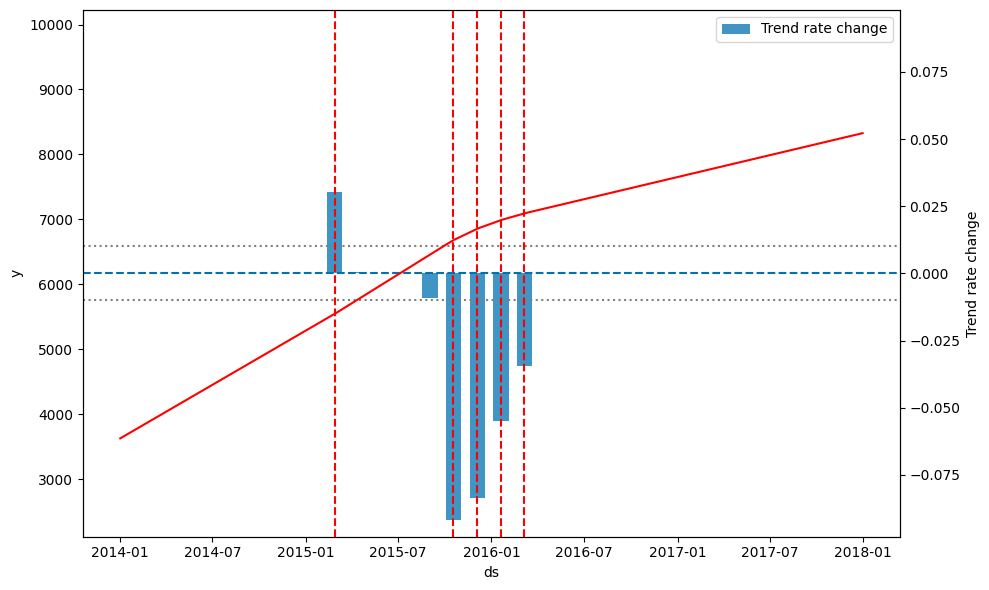

In [18]:
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'k'
add_changepoints_to_plot(ax1, model, forecast, trend=True)
ax1.set_xlabel('ds')
ax1.set_ylabel('y', color=color)
##
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(ylims[0] + 5000, ylims[1] - 7000)
##
ax1.grid(False)

## Overlay on ax1
ax2 = ax1.twinx()

color = '#0072B2'
ax2.set_ylabel('Trend rate change')
ax2.bar(changepoints, model.params['delta'][0], width=30, color=color, alpha=.75, label='Trend rate change')
ax2.tick_params(axis='y', labelcolor='k')
ax2.axhline(y=0, c=color, ls='--')
ax2.axhline(y=.01, c='gray', ls=':')
ax2.axhline(y=-.01, c='gray', ls=':')
ax2.set_ylim(top=-ax2.get_ylim()[0], bottom=ax2.get_ylim()[0])

ax2.legend()

fig.tight_layout()
##
ax1.set_zorder(1)
ax1.patch.set_visible(False)
plt.show()

## ***Regularizing changepoints***

In [19]:
## control changepoints , n_changepoints
model = Prophet(seasonality_mode='multiplicative',
                yearly_seasonality=4,
                n_changepoints=5)

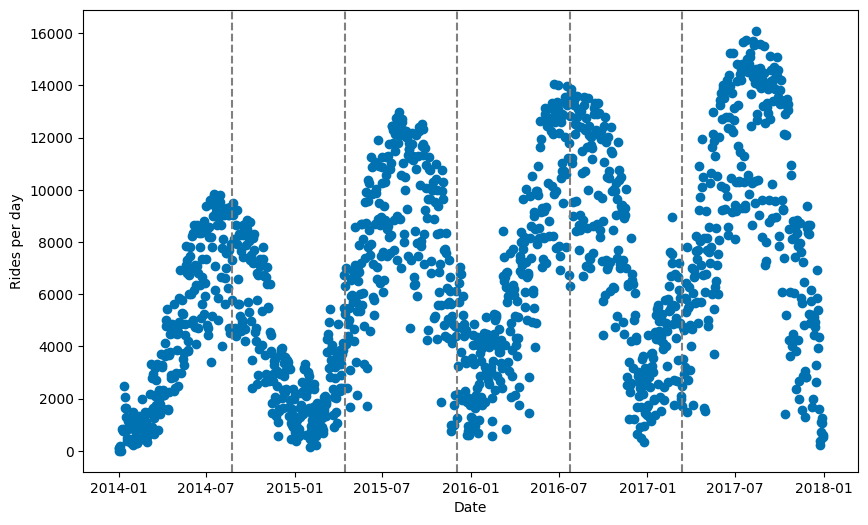

In [20]:
plt.figure(figsize=(10, 6))
plt.scatter(df['ds'], df['y'], c='#0072B2')
for cp in set_changepoints(df, 5, .8):
    plt.axvline(x=cp, c='gray', ls='--')
plt.xlabel('Date')
plt.ylabel('Rides per day')
plt.show()

In [21]:
## change changepoints range , place at first 50% timeseries
model = Prophet(seasonality_mode='multiplicative',
                yearly_seasonality=4,
                changepoint_range=.5)

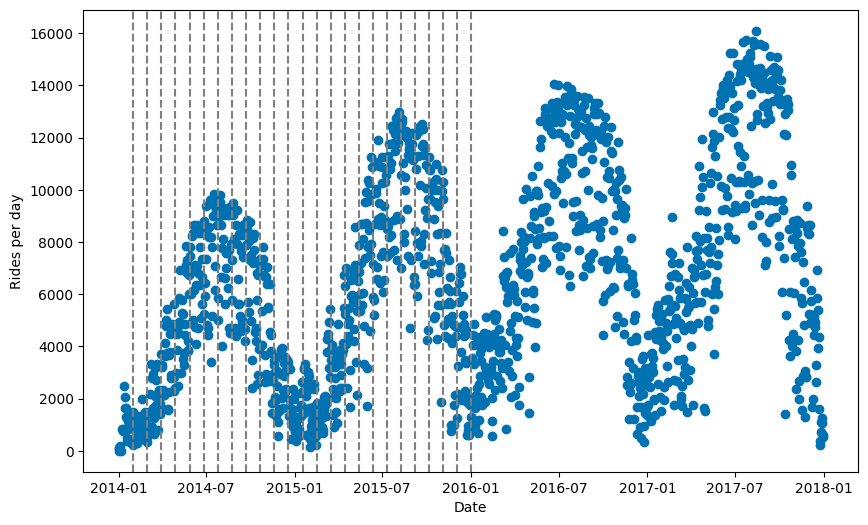

In [22]:
plt.figure(figsize=(10, 6))
plt.scatter(df['ds'], df['y'], c='#0072B2')
for cp in set_changepoints(df, 25, .5):
    plt.axvline(x=cp, c='gray', ls='--')
plt.xlabel('Date')
plt.ylabel('Rides per day')
plt.show()

15:19:44 - cmdstanpy - INFO - Chain [1] start processing
15:19:44 - cmdstanpy - INFO - Chain [1] done processing


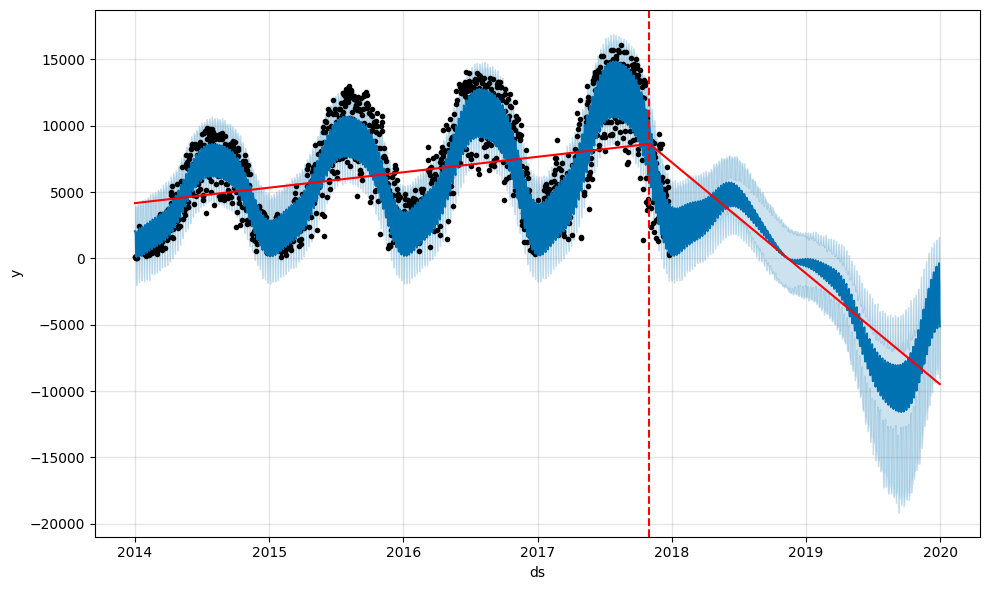

In [23]:
## Bad performance of Prophet changepoint capture when it is placed at too late position

model = Prophet(seasonality_mode='multiplicative',
                yearly_seasonality=4,
                changepoints=['2017-11-01'], # late position
                changepoint_prior_scale=50) # nomally 0.001 to 0.5

model.fit(df)
future = model.make_future_dataframe(periods=365 * 2)
forecast = model.predict(future)
fig = model.plot(forecast)
add_changepoints_to_plot(fig.gca(), model, forecast)
plt.show()

15:20:55 - cmdstanpy - INFO - Chain [1] start processing
15:20:55 - cmdstanpy - INFO - Chain [1] done processing


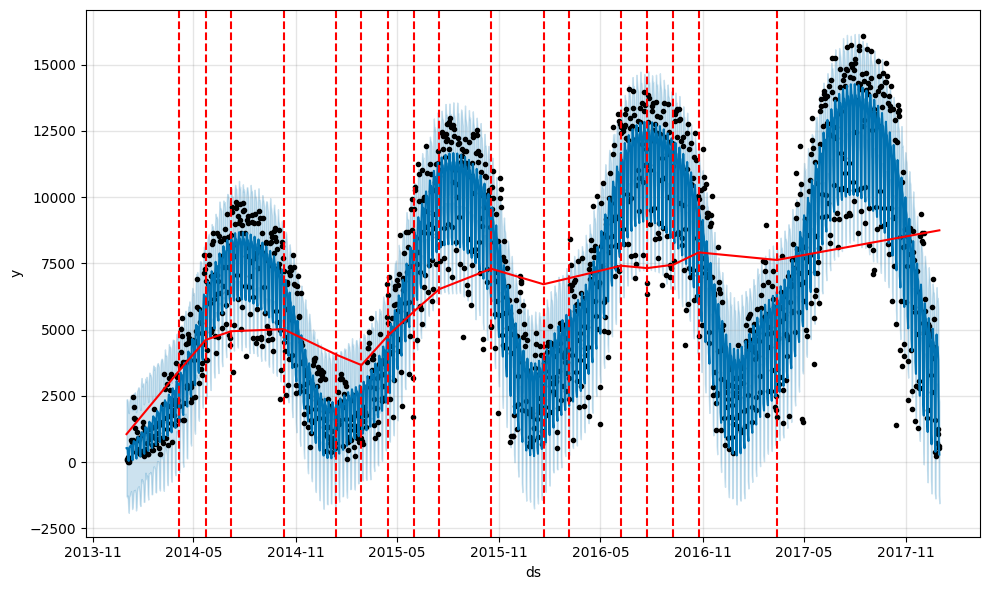

In [24]:
## large prior scale , overfitting

model = Prophet(seasonality_mode='multiplicative',
                yearly_seasonality=4,
                changepoint_prior_scale=1)
model.fit(df)
forecast = model.predict()
fig = model.plot(forecast)
add_changepoints_to_plot(fig.gca(), model, forecast)
plt.show()

15:21:15 - cmdstanpy - INFO - Chain [1] start processing
15:21:15 - cmdstanpy - INFO - Chain [1] done processing


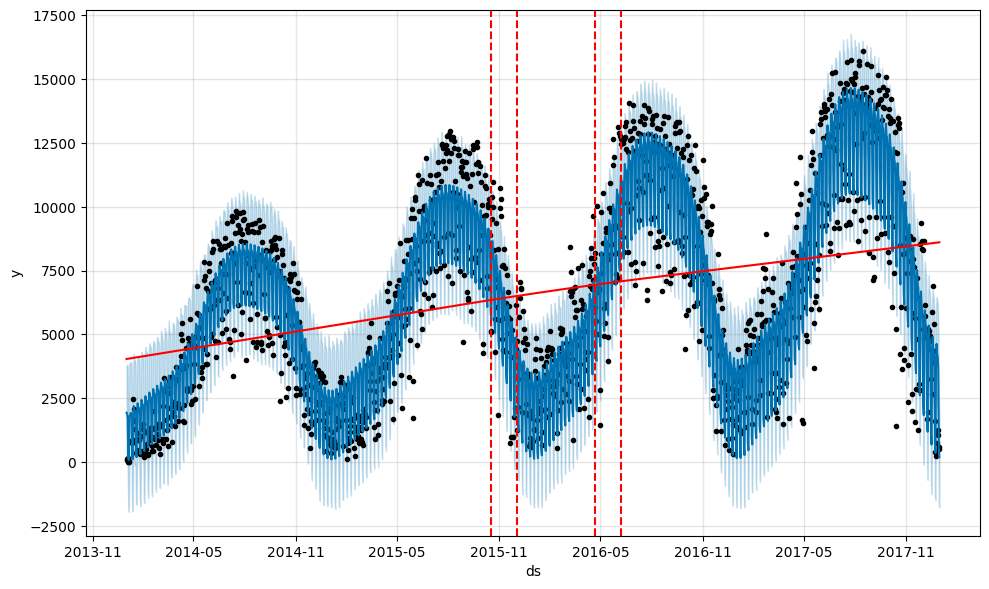

In [25]:
# small prior scale , under fitting
model = Prophet(seasonality_mode='multiplicative',
                yearly_seasonality=4,
                changepoint_prior_scale=.007)
model.fit(df)
forecast = model.predict()
fig = model.plot(forecast)
add_changepoints_to_plot(fig.gca(), model, forecast)
plt.show()

## ***Specifying custom changepoint locations***

In [26]:
## James Rodriguez instagram likes dataset

df = pd.read_csv('../data/instagram_jamesrodriguez10.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.columns = ['ds', 'y']

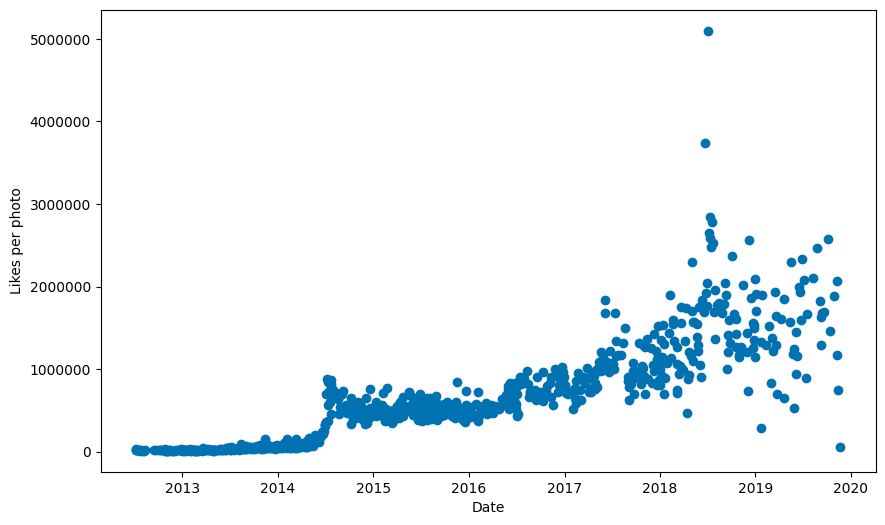

In [27]:
plt.figure(figsize=(10, 6))
plt.scatter(x=df['ds'], y=df['y'], c='#0072B2')
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel('Date')
plt.ylabel('Likes per photo')
plt.show()

In [28]:
wc_2014 = pd.DataFrame({'holiday': 'World Cup 2014',
                        'ds': pd.to_datetime(['2014-06-12']),
                        'lower_window': 0,
                        'upper_window': 31})
wc_2018 = pd.DataFrame({'holiday': 'World Cup 2018',
                        'ds': pd.to_datetime(['2018-06-14']),
                        'lower_window': 0,
                        'upper_window': 31})
signing = pd.DataFrame({'holiday': 'Bayern Munich',
                        'ds': pd.to_datetime(['2017-07-11']),
                        'lower_window': 0,
                        'upper_window': 14})

special_events = pd.concat([wc_2014, wc_2018, signing])

In [29]:
special_events

,holiday,ds,lower_window,upper_window
0,World Cup 2014,2014-06-12,0,31
0,World Cup 2018,2018-06-14,0,31
0,Bayern Munich,2017-07-11,0,14


In [30]:
# specify our custom changepoints

changepoints = ['2014-06-12', # wc2014 start
                '2014-07-13', # wc2014 end
                '2017-07-11', # signing start
                '2017-07-31', # signing end
                '2018-06-14', # wc2018 start
                '2018-07-15'] # wc2018 end

In [31]:
model = Prophet(seasonality_mode='multiplicative',
                holidays=special_events,
                yearly_seasonality=False,
                weekly_seasonality=False,
                changepoint_prior_scale=1, # do experiment
                changepoints=changepoints)

16:11:08 - cmdstanpy - INFO - Chain [1] start processing
16:11:08 - cmdstanpy - INFO - Chain [1] done processing


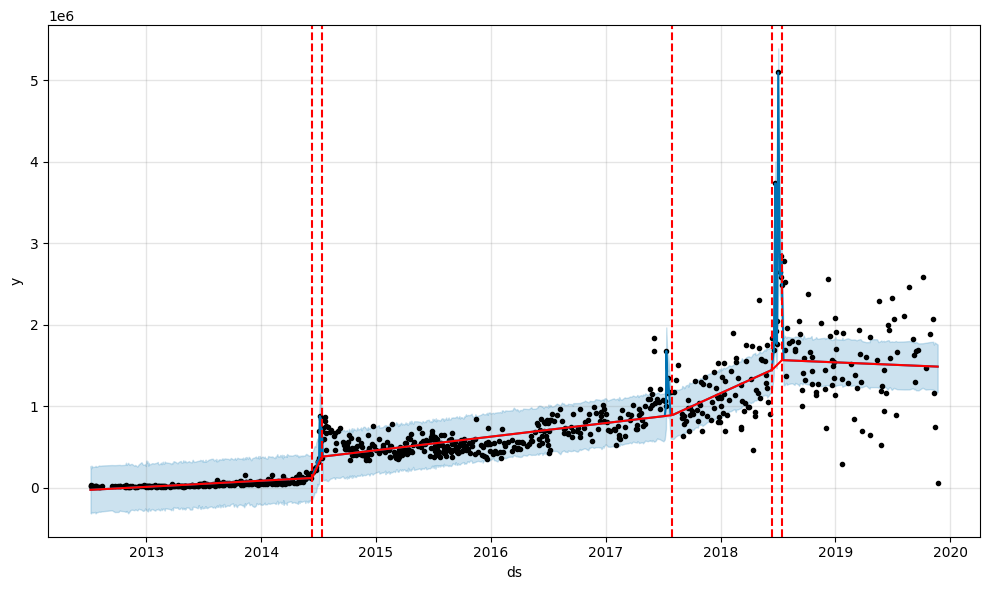

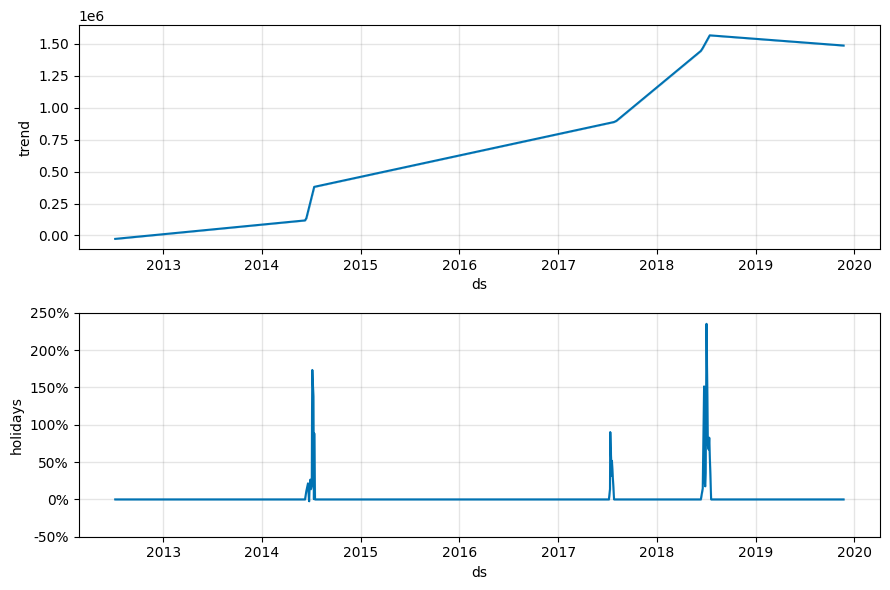

In [32]:
model.fit(df)
forecast = model.predict()
fig = model.plot(forecast)
add_changepoints_to_plot(fig.gca(), model, forecast)
plt.show()
fig2 = model.plot_components(forecast)
plt.show()

In [38]:
forecast[ forecast['holidays'] != 0 ].T

,227,228,229,230,231,232,233,234,235,236,...,663,664,665,666,667,668,669,670,671,672
ds,2014-06-14 00:00:00,2014-06-20 00:00:00,2014-06-24 00:00:00,2014-06-25 00:00:00,2014-06-29 00:00:00,2014-06-30 00:00:00,2014-07-01 00:00:00,2014-07-04 00:00:00,2014-07-05 00:00:00,2014-07-06 00:00:00,...,2018-06-19 00:00:00,2018-06-24 00:00:00,2018-06-25 00:00:00,2018-06-28 00:00:00,2018-06-30 00:00:00,2018-07-03 00:00:00,2018-07-08 00:00:00,2018-07-11 00:00:00,2018-07-13 00:00:00,2018-07-15 00:00:00
trend,135329.870078,186035.756094,219839.680104,228290.661107,262094.585117,270545.56612,278996.547122,304349.49013,312800.471133,321251.452135,...,1466412.678866,1485528.063355,1489351.140253,1500820.370946,1508466.524742,1519935.755435,1539051.139925,1550520.370618,1558166.524414,1565812.678209
yhat_lower,-128897.850703,-55278.342698,-57775.550484,-32661.158222,48847.080394,21146.870807,33915.57802,46447.326198,417549.172718,591634.342399,...,1384520.256564,3438481.006687,1645646.510447,1465439.102311,1765104.175024,4822103.618223,2370689.485496,2305755.479315,2577431.249082,2191541.919483
yhat_upper,447515.559645,512875.921685,504099.565615,553678.222063,601196.293883,590549.640348,610838.766221,633049.920992,976088.739574,1157773.404447,...,1964080.489322,4004482.674436,2206222.126065,2034119.079347,2336377.492194,5392054.138701,2939925.995894,2871593.014016,3137599.827351,2744489.435932
trend_lower,135329.870078,186035.756094,219839.680104,228290.661107,262094.585117,270545.56612,278996.547122,304349.49013,312800.471133,321251.452135,...,1466412.678866,1485528.063355,1489351.140253,1500820.370946,1508466.524742,1519935.755435,1539051.139925,1550520.370618,1558166.524414,1565812.678209
trend_upper,135329.870078,186035.756094,219839.680104,228290.661107,262094.585117,270545.56612,278996.547122,304349.49013,312800.471133,321251.452135,...,1466412.678866,1485528.063355,1489351.140253,1500820.370946,1508466.524742,1519935.755435,1539051.139925,1550520.370618,1558166.524414,1565812.678209
Bayern Munich,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Bayern Munich_lower,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Bayern Munich_upper,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
World Cup 2014,0.113976,0.214989,-0.024244,0.099971,0.265429,0.152258,0.13753,0.178146,1.20891,1.73446,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
forecast[ forecast['Bayern Munich'] != 0 ].T

,572,573,574,575
ds,2017-07-11 00:00:00,2017-07-12 00:00:00,2017-07-17 00:00:00,2017-07-18 00:00:00
trend,880905.902647,881363.411554,883650.956086,884108.464992
yhat_lower,725401.451044,1371220.00038,860338.867848,1068551.692509
yhat_upper,1268846.339204,1966960.200379,1429911.363117,1632674.107859
trend_lower,880905.902647,881363.411554,883650.956086,884108.464992
trend_upper,880905.902647,881363.411554,883650.956086,884108.464992
Bayern Munich,0.138823,0.902136,0.314032,0.517522
Bayern Munich_lower,0.138823,0.902136,0.314032,0.517522
Bayern Munich_upper,0.138823,0.902136,0.314032,0.517522
World Cup 2014,0.0,0.0,0.0,0.0


### *changepoints location control - blending custom changepoiints with Prophets's default*

In [49]:
## mimic Prophet's 'set_changepoints' class
## set changepoints evenly

import numpy as np

def set_changepoints(df, n_changepoints=25, changepoint_range=.8):
    df = df.sort_values('ds').reset_index(drop=True)
    hist_size = int(np.floor(df.shape[0] * changepoint_range))
    if n_changepoints + 1 > hist_size:
        n_changepoints = hist_size - 1
        print('n_changepoints greater than number of '+
              'observations. Using {}.'.format(n_changepoints))
    if n_changepoints > 0:
        cp_indexes = (np.linspace(0,
                                  hist_size - 1,
                                  n_changepoints + 1).
                      round().astype(np.int16))
        changepoints = df.iloc[cp_indexes]['ds'].tail(-1)        
    else:
        # set empty changepoints
        changepoints = pd.Series(pd.to_datetime([]), name='ds')
    return changepoints

In [50]:
changepoints = set_changepoints(df, 5, .8)
changepoints

431    2013-09-11
862    2014-11-16
1293   2016-01-21
1724   2017-03-27
2155   2018-06-01
Name: ds, dtype: datetime64[ns]

In [47]:
new_changepoints = pd.Series(pd.to_datetime(['2014-05-02',
                                             '2014-08-25',
                                             '2017-07-31',
                                             '2018-06-14', 
                                             '2018-06-04',
                                             '2018-07-03']))

new_changepoints                                             

0   2014-05-02
1   2014-08-25
2   2017-07-31
3   2018-06-14
4   2018-06-04
5   2018-07-03
dtype: datetime64[ns]

In [55]:
# pandas , append error!
# In relatively recent pandas version, 1.5.2, append works, but gives a warning.
# In pd 2.0, append has been removed
# https://learning.oreilly.com/library/view/forecasting-time-series/9781800568532/B16867_07_Final_JC_ePub.xhtml#:-:text=append(new_changepoints)

# changepoints = changepoints.append(new_changepoints)
changepoints = changepoints._append(new_changepoints)
changepoints

431    2013-09-11
862    2014-11-16
1293   2016-01-21
1724   2017-03-27
2155   2018-06-01
0      2014-05-02
1      2014-08-25
2      2017-07-31
3      2018-06-14
4      2018-06-04
5      2018-07-03
dtype: datetime64[ns]

In [56]:
changepoints = changepoints.sort_values().reset_index(drop=True)
changepoints

0    2013-09-11
1    2014-05-02
2    2014-08-25
3    2014-11-16
4    2016-01-21
5    2017-03-27
6    2017-07-31
7    2018-06-01
8    2018-06-04
9    2018-06-14
10   2018-07-03
dtype: datetime64[ns]

16:37:59 - cmdstanpy - INFO - Chain [1] start processing
16:37:59 - cmdstanpy - INFO - Chain [1] done processing


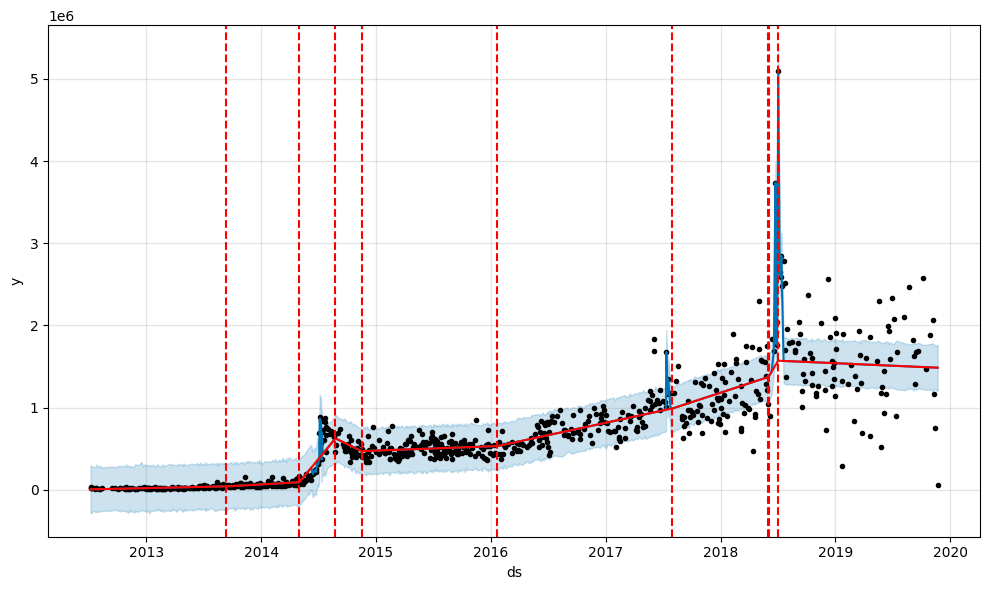

In [57]:
# model with custom + default changepoints

model = Prophet(seasonality_mode='multiplicative',
                holidays=special_events,
                yearly_seasonality=False,
                weekly_seasonality=False,
                changepoint_prior_scale=1,
                changepoints=changepoints)
model.fit(df)
forecast = model.predict()
fig = model.plot(forecast)
add_changepoints_to_plot(fig.gca(), model, forecast)
plt.show()